### PLAYGROUND FOR TOOSO FASHION CLICKSTREAM DATASET

This notebook show some simple code to open the CSV file you received, perform some basic transformation and, as an example, run a simple "anomaly" detection model.

Please refer to the original paper for further explanations, benchmarks and citation:

"Prediction is very hard, especially about conversion. Predicting user purchases from clickstream data in fashion e-commerce" -> https://arxiv.org/abs/1907.00400

This notebook can be run with Python3 installing the obvious dependencies.

#### REMEMBER THAT THE DATASET YOU RECEIVED IS CONFIDENTIAL AND YOU ARE LEGALLY RESPONSIBLE FOR ITS SECRECY

_import here packages and set some variables_

In [1]:
import csv
import itertools
from collections import Counter
import os
import pandas as pd
from sklearn.manifold import TSNE
import numpy as np
import keras
from datetime import datetime
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from operator import itemgetter

/Users/jacopotagliabue/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
LOCAL_FOLDER = '/Users/jacopotagliabue/Downloads' # set here the local SECURE folder in which you have stored the dataset
DATASET_NAME = 'small.csv'  # for illustration purposes, I'm running a small version of the dataset
DATASET_FILE = os.path.join(LOCAL_FOLDER, DATASET_NAME)

#### Read the file and parse sessions

First, we go through the dataset file. In the dataset, EACH ROW IS A DISTINCT EVENT that was recorded on the target website. An event may be a "view" - shopper viewing a product page - or, say, a "purchase", shopper buying something, etc.. Each event comes with anonymized information about the user performing it ("client_user_id_hash" for not-logged-in users, "target_user_id_hash" for users after login), standard temporal meta-data, a "session_id" and the list of product identifiers (possibly empty) connected to the event - for example, the id of the product that triggered the "view" event for the users. 

A _session_ is a list of consecutive events by a user within a browser, with less than 30 minutes between each pair of consecutive events. The dataset is already ordered by SESSION and TIME ASC, meaning that all events in the same sessions are consecutive rows, and all events appear in the same order as they were generated (first, the oldest event, etc.)

_In this example we parse the file and generate a list of events for further analysis below_

In [3]:
def map_site_action(event_type, product_action):
    """
    This function maps events to integers to make for easy downstream processing
    """
    if event_type in ['pageview', 'event'] and not product_action:
        return 1
    elif product_action == 'detail':
        return 2
    elif product_action == 'add':
        return 3
    elif product_action == 'remove':
        return 4
    elif product_action == 'purchase':
        return 5
    elif product_action == 'click':
        return 6
    else:
        raise Exception("User action not mappable {}".format(product_action))

    return None

In [4]:
def cut_and_pad_session(session, target_label, max_length, intervals, session_skus, current_timestamps):
    """
    This function pads sessions and assigns as label 1/0 depending on session containing a target event.
    If it contains a target event, it's cut just before that. 
    All session are padded to MAX_LENGTH, we also build a time interval list for future use.
    """
    session_object = dict()
    session_class = 0
    # if target label, cut session
    if target_label in session:
        target_index = session.index(target_label)
        session = session[0:target_index]
        # modify session label to positive label
        session_class = 1
    # fianally add properties to session object
    session_object['label'] = session_class
    session_object['values'] = [session[idx] if idx < len(session) else 0 for idx in range(max_length)]
    # time intervals vector
    session_object['times'] = [intervals[idx] if idx < len(intervals) else 0 for idx in range(max_length)]
    # skus
    session_object['skus'] = [session_skus[idx] if idx < len(session_skus) else [] for idx in range(max_length)]
    # timestamps
    session_object['timestamps'] = [current_timestamps[idx] if idx < len(current_timestamps) else 0 for idx in range(max_length)]
    
    return  session_object

In [5]:
# these variables will help filter out short/long sessions and identify the 'target' event (purchase)
MIN_SEQ_LENGTH = 5
MAX_SEQ_LENGTH = 200
TARGET_LABEL = 5

In [6]:
last_session_id = None
last_timestamp = None
current_session = []
current_intervals = []
current_timestamps = []
current_skus = []
sessions = []
with open(DATASET_FILE) as csvfile:
    reader = csv.DictReader(csvfile)
    # loop over all events
    for idx, row in enumerate(reader):
        # print all columns for first row
        if idx == 0:
            print(row.keys())
        # read the current values for the event
        current_session_id = row['session_id_hash']
        current_timestamp = int(row['server_timestamp_epoch_ms'])
        current_action = map_site_action(row['event_type'], row['product_action'])
        # this is an array of the form [SKU,SKU] but as a string in the csv!
        products = row['product_skus_hash'][1:-1] 
        if products:
            current_products = [p.strip() for p in products.split(',')]
        else:
            current_products = []
        # if the SKU was not recorded we use a placeholder label anyway
        if not current_products and current_action > 1:
            current_products = ['MISSING']
        if current_session_id != last_session_id and last_session_id:
            # check if we keep the session
            if len(current_session) >= MIN_SEQ_LENGTH and len(current_session) < MAX_SEQ_LENGTH:
                # check data is in order
                assert len(current_intervals) + 1 == len(current_session)
                padded_session = cut_and_pad_session(current_session, 
                                                     TARGET_LABEL, 
                                                     MAX_SEQ_LENGTH, 
                                                     current_intervals,
                                                     current_skus,
                                                     current_timestamps)
                sessions.append(padded_session)
            # reset session
            current_session = [current_action]
            current_intervals = []
            current_skus = [current_products]
            current_timestamps = [current_timestamp]
        else:
            current_session.append(current_action)
            current_skus.append(current_products)
            current_timestamps.append(current_timestamp)
            if last_timestamp:
                current_intervals.append(current_timestamp - last_timestamp)
        # update session id and timestamp
        last_session_id = current_session_id
        last_timestamp = current_timestamp

# check how many session we have
print("Total of {} sessions, first session is {}".format(len(sessions), (sessions[0])))

odict_keys(['session_id_hash', 'target_user_id_hash', 'client_user_id_hash', 'event_type', 'product_action', 'product_skus_hash', 'server_timestamp_epoch_ms', 'server_date', 'hashed_url'])
Total of 203958 sessions, first session is {'label': 0, 'values': [1, 1, 2, 1, 2, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'times': [11861, 188616, 14067, 181642, 40819, 62327, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [7]:
# sort them by BUY first to make sure we can plot a small subset
sessions = sorted(sessions, key=itemgetter('label'), reverse=True)

In [8]:
# it's ugly and slow, but let's print out some stats to see how much data we are dealing with
min_time =  min([s['timestamps'][0] for s in sessions])
max_time =  max([s['timestamps'][0] for s in sessions])
session_count = len(sessions)
session_lengths = [len([_ for _ in s['values'] if _ > 0]) for s in sessions]
print(np.median(session_lengths), min(session_lengths), max(session_lengths), np.mean(session_lengths))
all_skus = [[val for sublist in s['skus'] for val in sublist] for s in sessions]
flatten_skus = [val for sublist in all_skus for val in sublist]
sku_counter = Counter(flatten_skus)
print(sku_counter.most_common(5))
distinct_skus = set(flatten_skus)
print("Min time {}, max time {}, sessions {}, skus {}".format(
    datetime.utcfromtimestamp(int(min_time / 1000)),
    datetime.utcfromtimestamp(int(max_time / 1000)),
    session_count,
    len(distinct_skus)))

13.0 0 199 20.972592396473782
[('MISSING', 142209), ('590A2FAB43CBE2CF', 8941), ('77B8A76CB507265A', 7411), ('4F72DD11C6C70C46', 4425), ('372350A2C8561B20', 4146)]
Min time 2018-06-30 00:00:10, max time 2018-07-17 23:57:29, sessions 203958, skus 34738


#### Now, read data into pandas for some quick check and plot

In [9]:
# read data into pandas
session_df = pd.DataFrame([s['values'] for s in sessions])
session_df['label'] = [s['label'] for s in sessions]
# print ratios of target label
print(len(session_df[session_df['label'] == 1]) / len(session_df))
session_df.head()

0.042190058737583226


,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,label
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,1,1,2,3,1,4,1,2,3,...,0,0,0,0,0,0,0,0,0,1
2,2,1,2,1,2,1,2,1,2,3,...,0,0,0,0,0,0,0,0,0,1
3,1,1,1,2,1,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
4,1,1,2,1,2,1,2,3,1,1,...,0,0,0,0,0,0,0,0,0,1


In [10]:
PLOT_SIZE = len(session_df[session_df['label'] == 1]) * 2 # choose how many items to plot first

In [11]:
def tsne_plot(x1, y1):
    """
    Plot t-sne projection
    """
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x1)
    print("TSNE DONE!")

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y1 == 0), 0], X_t[np.where(y1 == 0), 1], marker='o', color='g', linewidth='1', alpha=0.8, label='Non Buy')
    plt.scatter(X_t[np.where(y1 == 1), 0], X_t[np.where(y1 == 1), 1], marker='o', color='r', linewidth='1', alpha=0.8, label='Buy')
    plt.legend(loc='best')
    plt.show()
    
    return

TSNE DONE!


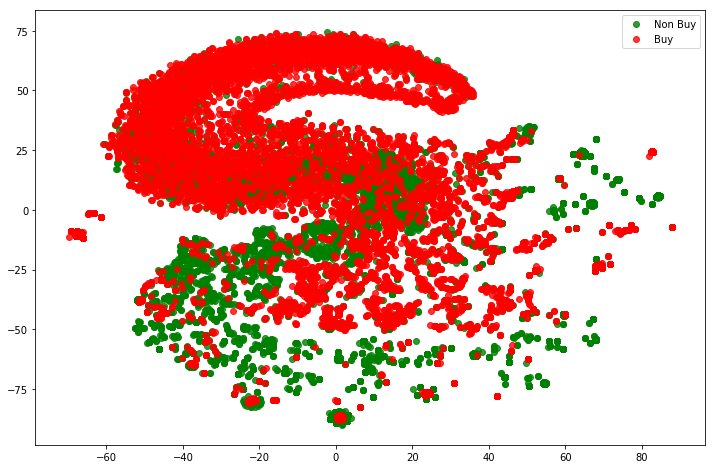

In [12]:
X = session_df.drop(['label'], axis = 1).values
Y = session_df["label"].values
# plot first N items
tsne_plot(X[:PLOT_SIZE], Y[:PLOT_SIZE])

#### Transform non-buy feature through a simple auto-encoder using Keras

The intuition here is that the encoder will learn a compact representation of the "typical" behavior, so that
we can run an "anomaly detection" to get the target rare event (for an illustration see for example -> https://www.kaggle.com/shivamb/semi-supervised-classification-using-autoencoders)

In [13]:
SAMPLE_SIZE = 20000  # how many items we want to feed to the encoder to save some time
EPOCHS = 10 # epoch for training

In [14]:
# prepare the auto-encoder model 
np.random.seed(42)
## input layer 
input_layer = Input(shape=(X.shape[1],))

## encoding part
encoded = Dense(2000, activation='relu', kernel_initializer=keras.initializers.RandomNormal(seed=42))(input_layer)
encoded = Dense(1200, activation='relu')(encoded)
encoded = Dense(1000, activation='relu')(encoded)
## decoding part
decoded = Dense(1000, activation='relu')(encoded)
decoded = Dense(1200, activation='relu')(decoded)
decoded = Dense(2000, activation='relu')(decoded)

## output layer
output_layer = Dense(X.shape[1], activation='relu')(decoded)
autoencoder = Model(input_layer, output_layer)
autoencoder.compile(optimizer="adadelta", loss="mse")

Instructions for updating:
Colocations handled automatically by placer.


In [15]:
x = session_df.drop(["label"], axis=1)
y = session_df["label"].values
x_norm = x[y == 0]
x_buy = x[y == 1]
print(len(x_norm), len(x_buy))

195353 8605


In [16]:
# fit autoencoder now
autoencoder.fit(x_norm[:SAMPLE_SIZE], x_norm[:SAMPLE_SIZE], 
                batch_size=256, epochs=EPOCHS, shuffle=True, 
                validation_split=0.20);

Instructions for updating:
Use tf.cast instead.
Train on 16000 samples, validate on 4000 samples
Epoch 1/10
16000/16000 [==============================] - 20s 1ms/step - loss: 0.1287 - val_loss: 0.1164
Epoch 2/10
16000/16000 [==============================] - 16s 978us/step - loss: 0.0824 - val_loss: 0.0743
Epoch 3/10
16000/16000 [==============================] - 15s 957us/step - loss: 0.0614 - val_loss: 0.0606
Epoch 4/10
16000/16000 [==============================] - 15s 965us/step - loss: 0.0527 - val_loss: 0.0500
Epoch 5/10
16000/16000 [==============================] - 16s 989us/step - loss: 0.0461 - val_loss: 0.0502
Epoch 6/10
16000/16000 [==============================] - 17s 1ms/step - loss: 0.0419 - val_loss: 0.0450
Epoch 7/10
16000/16000 [==============================] - 16s 982us/step - loss: 0.0374 - val_loss: 0.0391
Epoch 8/10
16000/16000 [==============================] - 14s 905us/step - loss: 0.0351 - val_loss: 0.0383
Epoch 9/10
16000/16000 [===========================

#### Transform events into the new space and re-draw the t-sne plot to see if anything changed!

In [17]:
# now generate representations for events in the latent space learned by the auto-encoder
hidden_representation = Sequential()
hidden_representation.add(autoencoder.layers[0])
hidden_representation.add(autoencoder.layers[1])
hidden_representation.add(autoencoder.layers[2])
hidden_representation.add(autoencoder.layers[3])
norm_hid_rep = hidden_representation.predict(x_norm[:PLOT_SIZE])
buy_hid_rep = hidden_representation.predict(x_buy)

In [ ]:
rep_x = np.append(norm_hid_rep, buy_hid_rep, axis=0)
y_n = np.zeros(norm_hid_rep.shape[0])
y_f = np.ones(buy_hid_rep.shape[0])
rep_y = np.append(y_n, y_f)
# plot
tsne_plot(rep_x, rep_y)

_Did we learn a good representation? Can we build a better enc-dec architecture?_

## HAVE FUN!